# Exercise - Train and evaluate multiclass classification models

Practice multiclass classification strategies and evaluation.

Train and evaluate multiclass classification models




Multiclass classification can be a combination of multiple binary classifiers. There are two ways to approach this problem:

- **One vs Rest (OVR)**, in which a classifier is created for each possible class value, with a positive outcome for cases where the prediction is *this* class, and negative predictions for cases where the prediction is any other class. A classification problem with four possible shape classes (*square*, *circle*, *triangle*, *hexagon*) would require four classifiers that predict:
    - *square* or not
    - *circle* or not
    - *triangle* or not
    - *hexagon* or not

- **One vs One (OVO)**, in which a classifier for each possible pair of classes is created. The classification problem with four shape classes would require the following binary classifiers:
    - *square* or *circle*
    - *square* or *triangle*
    - *square* or *hexagon*
    - *circle* or *triangle*
    - *circle* or *hexagon*
    - *triangle* or *hexagon*

In both approaches, the overall model that combines the classifiers generates a vector of predictions, in which the probabilities generated from the individual binary classifiers are used to determine which class to predict.

Fortunately, in most machine learning frameworks, including Scikit-Learn, implementing a multiclass classification model is not significantly more complex than binary classification - and in most cases, the estimators used for binary classification implicitly support multiclass classification by abstracting an OVR algorithm, an OVO algorithm, or by allowing a choice of either.

In [1]:
import pandas as pd

# load the training dataset
penguins = pd.read_csv('../../generated/data/raw/penguins.csv')

# Display a random sample of 10 observations
sample = penguins.sample(10)
print(sample)

     CulmenLength  CulmenDepth  FlipperLength  BodyMass  Species
172          50.2         14.3          218.0    5700.0        1
309          51.0         18.8          203.0    4100.0        2
230          45.2         13.8          215.0    4750.0        1
304          46.4         17.8          191.0    3700.0        2
253          55.9         17.0          228.0    5600.0        1
270          47.2         13.7          214.0    4925.0        1
84           37.3         17.8          191.0    3350.0        0
238          43.4         14.4          218.0    4600.0        1
97           40.3         18.5          196.0    4350.0        0
35           39.2         21.1          196.0    4150.0        0


The dataset contains the following columns:
* **CulmenLength**: The length in mm of the penguin's culmen (bill).
* **CulmenDepth**: The depth in mm of the penguin's culmen.
* **FlipperLength**: The length in mm of the penguin's flipper.
* **BodyMass**: The body mass of the penguin in grams.
* **Species**: An integer value that represents the species of the penguin.

The **Species** column is the label we want to train a model to predict. The dataset includes three possible species, which are encoded as 0, 1, and 2. The actual species names are revealed by the code below:

In [5]:
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']
print(sample.columns[0:5].values, 'SpeciesName')
for index, row in penguins.sample(10).iterrows():
    species_idx = int(row['Species'])
    print(f"[ {row['CulmenLength']} {row['CulmenDepth']} {row['FlipperLength']} {row['BodyMass']} {species_idx} ] {penguin_classes[species_idx]}")

['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 45.5 13.9 210.0 4200.0 1 ] Gentoo
[ 38.9 18.8 190.0 3600.0 0 ] Adelie
[ 35.7 18.0 202.0 3550.0 0 ] Adelie
[ 41.1 17.5 190.0 3900.0 0 ] Adelie
[ 38.5 17.9 190.0 3325.0 0 ] Adelie
[ 49.9 16.1 213.0 5400.0 1 ] Gentoo
[ 46.2 14.9 221.0 5300.0 1 ] Gentoo
[ 51.3 18.2 197.0 3750.0 2 ] Chinstrap
[ 34.1 18.1 193.0 3475.0 0 ] Adelie
[ 37.8 18.3 174.0 3400.0 0 ] Adelie


To explore the dataset after identifying the meanings of the features and labels, inspect its structure and summary statistics.

In [6]:
# Count the number of null values for each column
print(penguins.isnull().sum())

CulmenLength     2
CulmenDepth      2
FlipperLength    2
BodyMass         2
Species          0
dtype: int64


It looks like there are some missing feature values, but no missing labels.

To dig a little deeper and see the rows that contain nulls.

In [7]:
# Show rows containing nulls
print(penguins[penguins.isnull().any(axis=1)])

     CulmenLength  CulmenDepth  FlipperLength  BodyMass  Species
3             NaN          NaN            NaN       NaN        0
271           NaN          NaN            NaN       NaN        1


There are two rows that contain no feature values at all (*NaN* means "not a number"), so these won't be useful in training a model.

To discard them from the dataset.

In [8]:
# Drop rows containing NaN values
penguins=penguins.dropna()
#Confirm there are now no nulls
print(penguins.isnull().sum())


CulmenLength     0
CulmenDepth      0
FlipperLength    0
BodyMass         0
Species          0
dtype: int64


To explore how the features relate to the label by creating some box charts, then dealt with the missing values

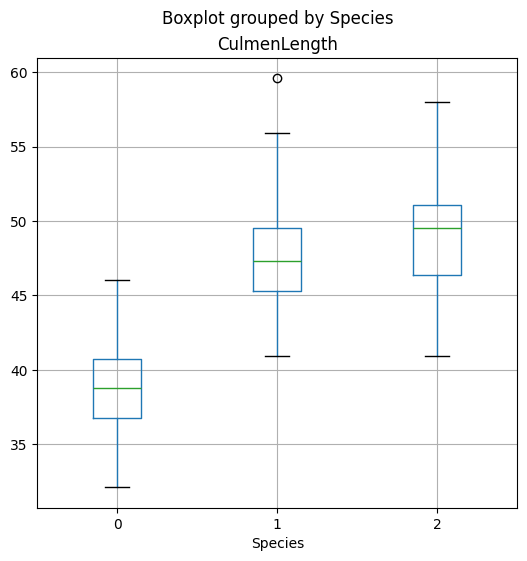

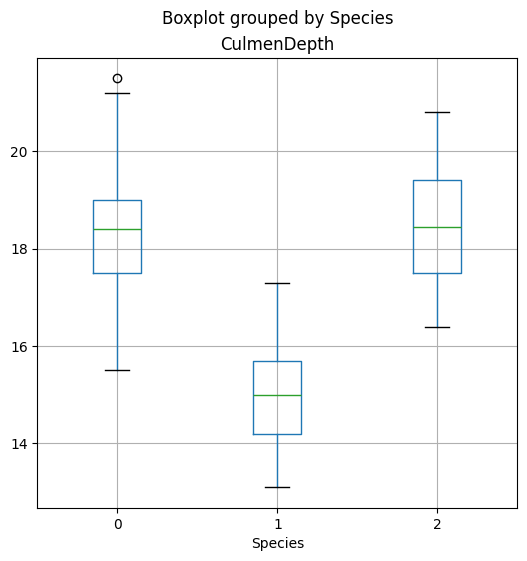

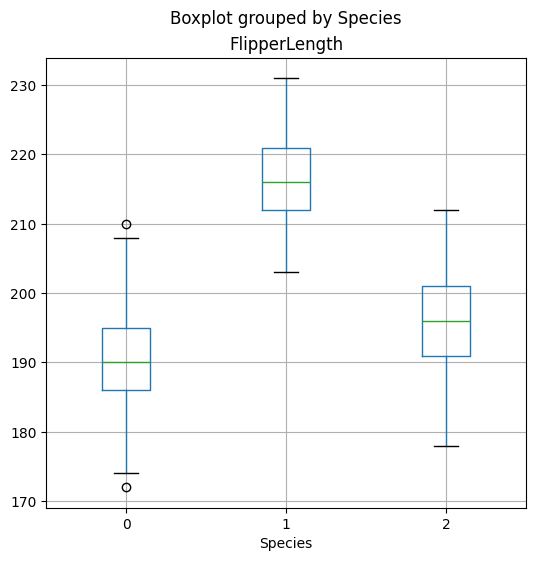

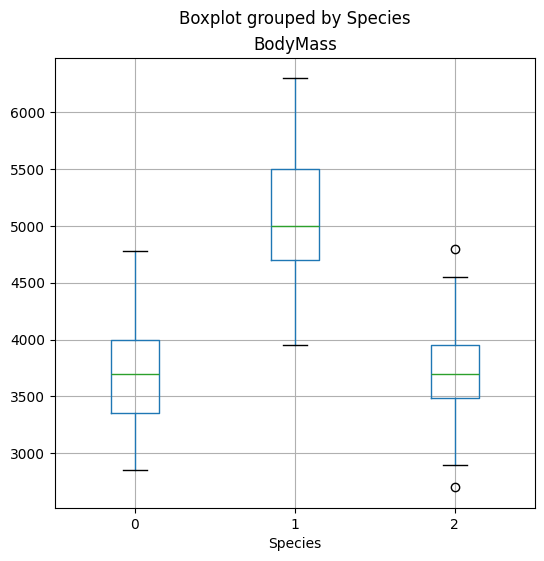

In [9]:
from matplotlib import pyplot as plt

penguin_features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
penguin_label = 'Species'
for col in penguin_features:
    penguins.boxplot(column=col, by=penguin_label, figsize=(6,6))
    plt.title(col)
plt.show()

To compare species 0 and 2 (Adelie and Chinstrap), examine culmen depth, flipper length, and body mass distributions to observe their similar profiles.

To highlight culmen differences, compare culmen length distributions for species 0 and 2 to show Chinstraps tend to have longer culmens.

To confirm species separation for modeling, compare Gentoo (species 1) feature distributions against the others to demonstrate its clearer differentiation, which should help train a better classification model.

### Prepare the data

1. To separate the data into features and the label, extract the feature columns and the `Species` column as the target.
2. To create training and validation subsets, split the dataset into two parts (training and validation) using an appropriate split ratio.
3. To preserve class proportions in each subset, apply \*stratification\* when performing the split so each subset maintains the original label distribution.

In [10]:
from sklearn.model_selection import train_test_split

# Separate features and labels
penguins_X, penguins_y = penguins[penguin_features].values, penguins[penguin_label].values

# Split data 70%-30% into training set and test set
x_penguin_train, x_penguin_test, y_penguin_train, y_penguin_test = train_test_split(penguins_X, penguins_y,
                                                                                    test_size=0.30,
                                                                                    random_state=0,
                                                                                    stratify=penguins_y)

print ('Training Set: %d, Test Set: %d \n' % (x_penguin_train.shape[0], x_penguin_test.shape[0]))

Training Set: 239, Test Set: 103 



### Train and evaluate a multiclass classifier

1. To fit a multiclass classification model, train a logistic regression estimator on the training features and corresponding training labels.
2. To leverage library support, use a Scikit\-Learn estimator (most classifiers natively support multiclass) and call `.fit()` with the training data.
3. To evaluate the fitted model, predict on the validation set and compute multiclass metrics such as accuracy, a confusion matrix, and per-class precision/recall.

In [14]:
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.1

# python
# Train a multinomial logistic regression (softmax) model
multi_model = LogisticRegression(C=1/reg, solver='lbfgs', max_iter=10000).fit(x_penguin_train, y_penguin_train)

print (multi_model)

LogisticRegression(C=10.0, max_iter=10000)


* To predict test labels, use the trained model to generate predictions for the test features.
* To evaluate prediction quality, compare the predicted labels with the actual labels using appropriate metrics such as accuracy, a confusion matrix, and per\-class precision/recall.

In [15]:
penguin_predictions = multi_model.predict(x_penguin_test)
print('Predicted labels: ', penguin_predictions[:15])
print('Actual labels   : ', y_penguin_test[:15])

Predicted labels:  [0 1 0 2 2 1 1 1 0 2 2 1 2 1 2]
Actual labels   :  [0 1 2 2 2 1 1 1 0 2 2 1 2 1 2]


To review a classification report.

In [16]:
from sklearn. metrics import classification_report

print(classification_report(y_penguin_test, penguin_predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103



As with binary classification, the report includes *precision* and *recall* metrics for each class. However, while with binary classification we could focus on the scores for the *positive* class; in this case, there are multiple classes so we need to look at an overall metric (either the macro or weighted average) to get a sense of how well the model performs across all three classes.

* To extract overall metrics separately, call Scikit\-Learn metric functions (for example, `precision_score`, `recall_score`, `accuracy_score`) on the predicted and true labels.
* To handle multiclass results, set the `average` parameter (e.g., `macro`, `micro`, or `weighted`) when computing precision and recall to choose the aggregation method for per\-class scores.

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Overall Accuracy:",accuracy_score(y_penguin_test, penguin_predictions))
print("Overall Precision:",precision_score(y_penguin_test, penguin_predictions, average='macro'))
print("Overall Recall:",recall_score(y_penguin_test, penguin_predictions, average='macro'))

Overall Accuracy: 0.970873786407767
Overall Precision: 0.9688405797101449
Overall Recall: 0.9608465608465608


To look at the confusion matrix for the model.

In [18]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
mcm = confusion_matrix(y_penguin_test, penguin_predictions)
print(mcm)

[[44  0  1]
 [ 0 37  0]
 [ 2  0 19]]


The confusion matrix shows the intersection of predicted and actual label values for each class, where the diagonal intersections from top-left to bottom-right indicate the number of correct predictions.

When dealing with multiple classes, it's generally more intuitive to visualize this as a heat map.

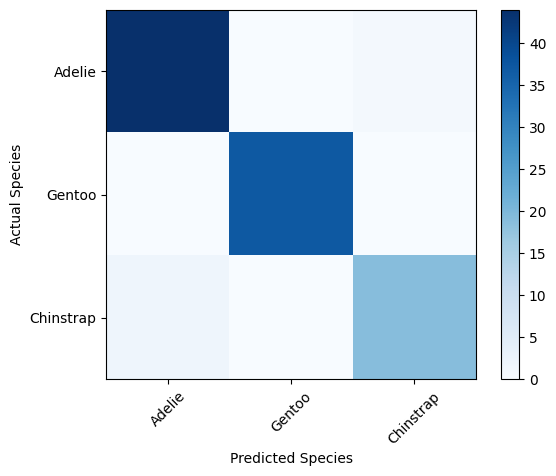

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

The darker squares in the confusion matrix plot indicate high numbers of cases, and you can hopefully see a diagonal line of darker squares indicating cases where the predicted and actual label are the same.

In the case of a multiclass classification model, a single ROC curve showing true positive rate vs false positive rate is not possible.

To create a ROC chart for each class, compute the false positive rate and true positive rate for each class using a One\-vs\-Rest (OVR) comparison, and plot a ROC curve for each class.

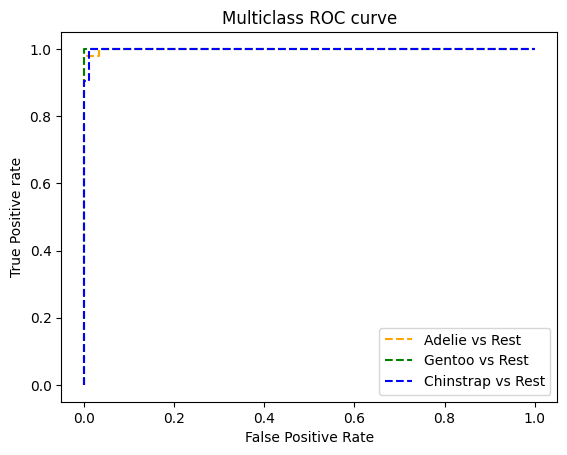

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Get class probability scores
penguin_prob = multi_model.predict_proba(x_penguin_test)

# Get ROC metrics for each class
fpr = {}
tpr = {}
thresh ={}
for i in range(len(penguin_classes)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_penguin_test, penguin_prob[:,i], pos_label=i)

# Plot the ROC chart
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=penguin_classes[0] + ' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=penguin_classes[1] + ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=penguin_classes[2] + ' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

To quantify ROC performance, compute the area under the curve \(AUC\) for each One\-vs\-Rest \(OVR\) ROC curve and average those AUC scores to produce an aggregate AUC.

In [21]:
auc = roc_auc_score(y_penguin_test,penguin_prob, multi_class='ovr')
print('Average AUC:', auc)

Average AUC: 0.9993574254297553


### Preprocess data in a pipeline

To apply preprocessing consistently, create a pipeline that scales numeric features in a transformation step before fitting the model.

To test alternative algorithms, replace the estimator in the pipeline (for example, use a \*support vector machine\*) and compare results to determine whether scaling improves the penguin predictor.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Define preprocessing for numeric columns (scale them)
feature_columns = [0,1,2,3]
feature_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('preprocess', feature_transformer, feature_columns)])

# Create training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', SVC(probability=True))])


# fit the pipeline to train a linear regression model on the training set
multi_model = pipeline.fit(x_penguin_train, y_penguin_train)
print (multi_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocess',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3])])),
                ('regressor', SVC(probability=True))])


To evaluate the new model.

Overall Accuracy: 0.9805825242718447
Overall Precision: 0.9767195767195768
Overall Recall: 0.9767195767195768
Average AUC: 0.9990361381446328


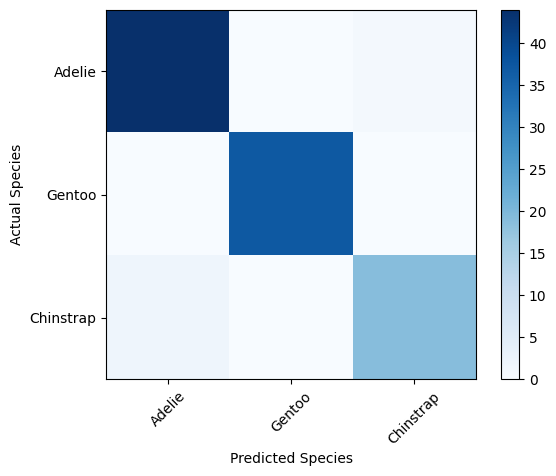

In [23]:
# Get predictions from test data
penguin_predictions = multi_model.predict(x_penguin_test)
penguin_prob = multi_model.predict_proba(x_penguin_test)

# Overall metrics
print("Overall Accuracy:", accuracy_score(y_penguin_test, penguin_predictions))
print("Overall Precision:", precision_score(y_penguin_test, penguin_predictions, average='macro'))
print("Overall Recall:", recall_score(y_penguin_test, penguin_predictions, average='macro'))
print('Average AUC:', roc_auc_score(y_penguin_test,penguin_prob, multi_class='ovr'))

# Confusion matrix
plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Predicted Species")
plt.ylabel("Actual Species")
plt.show()

### Use the model with new data observations

To save the newest trained model so to use it again later.

In [24]:
import joblib

# Save the model as a pickle file
filename = '../../generated/models/penguin_model.pkl'
joblib.dump(multi_model, filename)

['../../generated/models/penguin_model.pkl']

To use the model to predict the class of a new penguin observation.

In [25]:
# Load the model from the file
multi_model = joblib.load(filename)

# The model accepts an array of feature arrays (so you can predict the classes of multiple penguin observations in a single call)
# We'll create an array with a single array of features, representing one penguin
x_new = np.array([[50.4,15.3,224,5550]])
print ('New sample: {}'.format(x_new[0]))

# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one penguin, so our prediction is the first one in the resulting array.
penguin_pred = multi_model.predict(x_new)[0]
print('Predicted class is', penguin_classes[penguin_pred])

New sample: [  50.4   15.3  224.  5550. ]
Predicted class is Gentoo


To submit a batch of penguin observations, send them to the model and collect the prediction returned for each observation.

In [26]:
# This time our input is an array of two feature arrays
x_new = np.array([[49.5,18.4,195, 3600],
         [38.2,20.1,190,3900]])
print ('New samples:\n{}'.format(x_new))

# Call the web service, passing the input data
predictions = multi_model.predict(x_new)

# Get the predicted classes.
for prediction in predictions:
    print(prediction, '(' + penguin_classes[prediction] +')')

New samples:
[[  49.5   18.4  195.  3600. ]
 [  38.2   20.1  190.  3900. ]]
2 (Chinstrap)
0 (Adelie)


## Summary

Classification is one of the most common forms of machine learning, and by following the basic principles we've discussed in this notebook you should be able to train and evaluate classification models with Scikit-Learn. It's worth spending some time investigating classification algorithms in more depth, and a good starting point is the [Scikit-Learn documentation](https://scikit-learn.org/stable/user_guide.html).